<a href="https://colab.research.google.com/github/itamarKraitman/2024DeepLearningCourseProject/blob/main/Main_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Attention, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
!pip install forex-python

from forex_python.converter import CurrencyRates

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer

### Project Objective
Predicting annual salary in dollars for data science positions based on various data such as role definition, location, company size, and employee location

### Reading Data From Source

In [3]:
data = pd.read_csv('ds_salaries.csv')
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


### Describing Features

**work_year**: The year the salary was paid.
**experience_level**: The experience level in the job during the year
**employment_type**: The type of employment for the role
**job_title**: The role worked in during the year.
**salary**: The total gross salary amount paid.
**salary_currency**: The currency of the salary paid as an ISO 4217 currency code.
**salary_in_usd**: The salary in USD
**employee_residence**: Employee's primary country of residence in during the work year as an ISO 3166 country code.
**remote_ratio**: The overall amount of work done remotely
**company_location**: The country of the employer's main office or contracting branch
**company_size**: The median number of people that worked for the company during the year

### Data Cleaning

In [4]:
# No Nan values so no action should be done
data.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

### EDA

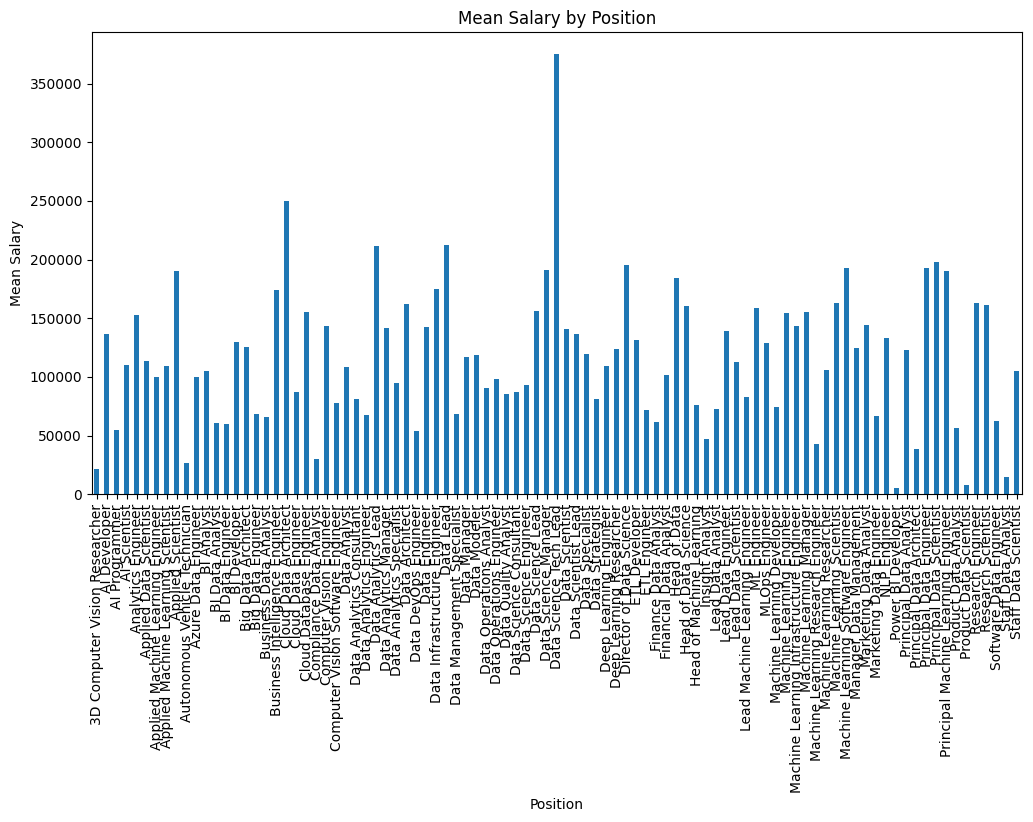

In [5]:
mean_salary_by_position = data.groupby('job_title')['salary_in_usd'].mean()

plt.figure(figsize=(12,6))
mean_salary_by_position.plot(kind='bar')
plt.title('Mean Salary by Position')
plt.xlabel('Position')
plt.ylabel('Mean Salary')
plt.show()

In [6]:
job_title_counts = data['job_title'].value_counts()
job_title_counts.reset_index()
# pd.DataFrame(job_title_counts, columns=['job_title', 'count'])

,index,job_title
0,Data Engineer,1040
1,Data Scientist,840
2,Data Analyst,612
3,Machine Learning Engineer,289
4,Analytics Engineer,103
...,...,...
88,Principal Machine Learning Engineer,1
89,Azure Data Engineer,1
90,Manager Data Management,1
91,Marketing Data Engineer,1


<ipython-input-7-b273f40f327d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='job_title', y='index', data=job_title_counts, palette='viridis')


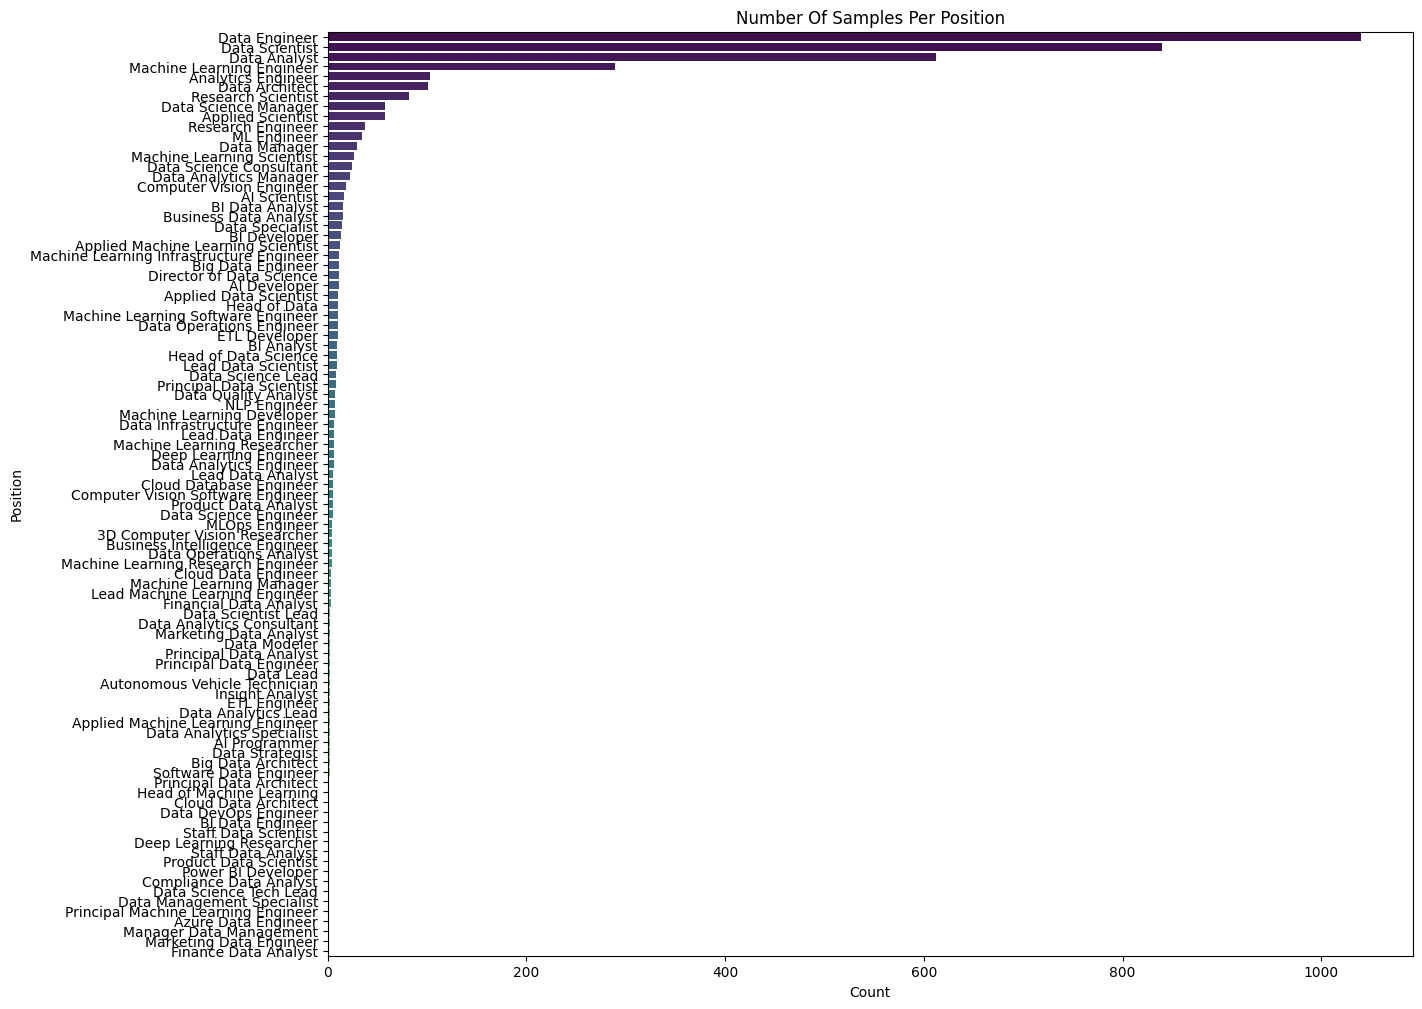

In [7]:
plt.figure(figsize=(14,12))
job_title_counts = data['job_title'].value_counts().reset_index()

sns.barplot(x='job_title', y='index', data=job_title_counts, palette='viridis')
plt.title('Number Of Samples Per Position')
plt.xlabel('Count')
plt.ylabel('Position')
plt.show()

### Preprocessing
Converting categorical features to numerical using encoding methods

In [8]:
# let's look which features are not numerical and should be converted
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


We can observe that the data set has 7 not numerical features which should be converted:
 experience_level, employment_type, job_title, salary_currency, employee_residence, company_location, and company_size

In [9]:
cols_to_normalize = ['salary', 'salary_in_usd']
data[cols_to_normalize] = data[cols_to_normalize] / 100000


In [10]:
data[cols_to_normalize]

,salary,salary_in_usd
0,0.800,0.85847
1,0.300,0.30000
2,0.255,0.25500
3,1.750,1.75000
4,1.200,1.20000
...,...,...
3750,4.120,4.12000
3751,1.510,1.51000
3752,1.050,1.05000
3753,1.000,1.00000


##### Encoding
Since there are some categorical features, we decided to use Label encoder and One-Hot encoder.
* For features with low number of unique values (as a thumb rule we decided it to be <=20) we used Label encoder.
* for features with high number of unique values we used One-Hot encoder.

In [11]:
# let's inspect the unique values count for each non-numeric column
columns_to_encode = [column for column in data.columns if data[column].dtype == 'object']

for column in columns_to_encode:
    print(column,
          ", ",data[column].nunique())

experience_level ,  4
employment_type ,  4
job_title ,  93
salary_currency ,  20
employee_residence ,  78
company_location ,  72
company_size ,  3


In [12]:
# Encoding non-numeric columns based on the number of unique values they have
# label_encoder = LabelEncoder() # for columns with less than 20 unique values
# one_hot_encoder = OneHotEncoder(sparse_output=False) # for columns with more than 20 unique values

# for column in columns_to_encode:
#     if data[column].nunique() <= 20:
#         data[column] = label_encoder.fit_transform(data[column])
#     else:
#         one_hot_encoded = pd.get_dummies(data[column], prefix=column)
#         data[one_hot_encoded.columns] = one_hot_encoded.astype(int) # converting encoded values to be 0 and 1
#         data = pd.concat([data, one_hot_encoded], axis=1)
#         data.drop(column, axis=1, inplace=True)


# Extract features and target variable
data_X = data.drop('salary_in_usd', axis=1)
salary_in_usd_Y = data['salary_in_usd']

numeric_features = data_X.select_dtypes(include=[np.number])
numeric_transformer = StandardScaler()

categorical_features = data_X.select_dtypes(include=['object'])
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features.columns),
        ('cat', categorical_transformer, categorical_features.columns)
    ])
print("------------------------------------------------")

# print(preprocessor)

# Split the dataset into training and testing sets
x_train, x_rest, y_train, y_rest = train_test_split(data_X, salary_in_usd_Y, train_size=0.6)
x_test, x_valid, y_test, y_valid = train_test_split(x_rest, y_rest, train_size=0.5)
# print("------------------------------------------------")
# print(x_test)
# Apply transformers to training and testing sets
X_train_preprocessed = preprocessor.fit_transform(x_train)
print("------------------------------------------------")

print(X_train_preprocessed)
X_valid_preprocessed = preprocessor.transform(x_valid)


------------------------------------------------
------------------------------------------------
[[-0.55780135 -0.16651223 -0.94229193 ...  0.          1.
   0.        ]
 [ 0.8984286  -0.02420609 -0.94229193 ...  0.          1.
   0.        ]
 [ 0.8984286  -0.1901424  -0.94229193 ...  0.          1.
   0.        ]
 ...
 [-2.01403131 -0.04836137  1.11088382 ...  1.          0.
   0.        ]
 [-0.55780135  0.00415012  1.11088382 ...  0.          1.
   0.        ]
 [-0.55780135 -0.1074368  -0.94229193 ...  0.          1.
   0.        ]]


In [13]:
# print(X_test_preprocessed)

### Preparing the Data for training process
* Scaling- using standard scaler
* Train-Test-Validation split

In [14]:
# data_X, salary_in_usd = data.drop(['salary_in_usd'], axis=1), data['salary_in_usd']

##### Scaling

In [15]:
# st_scaler = StandardScaler()
# data_X = st_scaler.fit_transform(data_X) z=(x-u)/s

In [16]:
# # Creating train, test and validation sets
# x_train, x_rest, y_train, y_rest = train_test_split(data_X, salary_in_usd, train_size=0.8)
# x_test, x_valid, y_test, y_valid = train_test_split(x_rest, y_rest, train_size=0.5)

In [17]:
x_train

,work_year,experience_level,employment_type,job_title,salary,salary_currency,employee_residence,remote_ratio,company_location,company_size
3282,2022,SE,FT,Data Engineer,0.600,GBP,GB,0,GB,M
695,2023,SE,FT,Data Engineer,1.684,USD,US,0,US,M
1048,2023,MI,FT,Insight Analyst,0.420,GBP,GB,0,GB,M
26,2023,SE,FT,Business Intelligence Engineer,1.564,USD,US,0,US,M
2638,2022,SE,FT,Data Analyst,1.150,USD,US,100,US,M
...,...,...,...,...,...,...,...,...,...,...
102,2023,SE,FT,Data Analyst,0.650,USD,US,0,US,M
1500,2023,SE,FT,Data Engineer,0.850,USD,US,100,US,M
3510,2021,MI,FT,Data Architect,1.500,USD,US,100,US,L
2735,2022,SE,FT,Data Architect,1.900,USD,US,100,US,M


### Performing linear regression

In [18]:
# Building a Linear Regression model
linear_regression = Sequential([
    Dense(1, input_shape=(X_train_preprocessed.shape[1],), activation='linear')
])

linear_regression.compile(optimizer=Adam(learning_rate=0.001),  # Adjust learning rate as needed
              loss='mse',  # Mean Squared Error
              metrics=['mae', 'mse'])  # Track Mean Absolute Error and Mean Squared Error during

# Training the model
linear_history = linear_regression.fit(X_train_preprocessed, y_train,
                    validation_data=(X_valid_preprocessed, y_valid),
                    epochs=400,
                    batch_size=32,
                    verbose=2)

linear_evaluation_result = linear_regression.evaluate(X_valid_preprocessed, y_valid, verbose=0)


Epoch 1/400
71/71 - 1s - loss: 1.3527 - mae: 0.9935 - mse: 1.3527 - accuracy: 0.0102 - val_loss: 0.9500 - val_mae: 0.7868 - val_mse: 0.9500 - val_accuracy: 0.0173 - 1s/epoch - 16ms/step
Epoch 2/400
71/71 - 0s - loss: 0.6692 - mae: 0.6416 - mse: 0.6692 - accuracy: 0.0262 - val_loss: 0.5236 - val_mae: 0.5394 - val_mse: 0.5236 - val_accuracy: 0.0240 - 232ms/epoch - 3ms/step
Epoch 3/400
71/71 - 0s - loss: 0.4066 - mae: 0.4803 - mse: 0.4066 - accuracy: 0.0271 - val_loss: 0.3735 - val_mae: 0.4497 - val_mse: 0.3735 - val_accuracy: 0.0240 - 238ms/epoch - 3ms/step
Epoch 4/400
71/71 - 0s - loss: 0.3148 - mae: 0.4233 - mse: 0.3148 - accuracy: 0.0271 - val_loss: 0.3216 - val_mae: 0.4176 - val_mse: 0.3216 - val_accuracy: 0.0240 - 230ms/epoch - 3ms/step
Epoch 5/400
71/71 - 0s - loss: 0.2789 - mae: 0.4005 - mse: 0.2789 - accuracy: 0.0271 - val_loss: 0.2973 - val_mae: 0.4020 - val_mse: 0.2973 - val_accuracy: 0.0240 - 192ms/epoch - 3ms/step
Epoch 6/400
71/71 - 0s - loss: 0.2592 - mae: 0.3856 - mse: 0.2

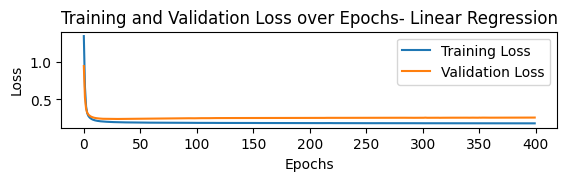

In [19]:
plt.plot(linear_history.history['loss'], label='Training Loss')
plt.plot(linear_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs- Linear Regression')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplots_adjust(top=0.2, bottom=0.0)

plt.show()

In [20]:
# Building the MLP model
mlp_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_preprocessed.shape[1]),
    BatchNormalization(),

    # Hidden layer 1
    Dense(256, activation='relu'),
    Dropout(0.3),  # Dropout for regularization

    # Hidden layer 2
    Dense(128, activation='relu'),
    Dropout(0.3),  # Dropout for regularization

    # Output layer: Using 'linear' activation for regression tasks
    Dense(1, activation='linear')
])

# Compile the model
mlp_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae', 'mse'])

# Model summary
mlp_model.summary()

# Train the model
mlp_history = mlp_model.fit(X_train_preprocessed, y_train,
                    validation_data=(X_valid_preprocessed, y_valid),
                    epochs=400,  # Adjust the number of epochs based on when convergence occurs
                    batch_size=32,  # Adjust batch size according to your dataset size and memory capacity
                    verbose=2)

# Evaluate the model on the validation set
mlp_evaluation_result = mlp_model.evaluate(X_valid_preprocessed, y_valid, verbose=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               29824     
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

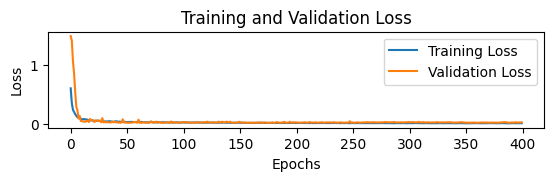

In [21]:
# Plotting the training and validation loss
plt.plot(mlp_history.history['loss'], label='Training Loss')
plt.plot(mlp_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplots_adjust(top=0.2, bottom=0.0)

plt.show()

## Trying to improve the model
1. Dealing with imbalanced data using weight sampels

In [22]:
for col in data.columns:
  col_counts = data[col].value_counts()
  print(col_counts)

2023    1785
2022    1664
2021     230
2020      76
Name: work_year, dtype: int64
SE    2516
MI     805
EN     320
EX     114
Name: experience_level, dtype: int64
FT    3718
PT      17
CT      10
FL      10
Name: employment_type, dtype: int64
Data Engineer                          1040
Data Scientist                          840
Data Analyst                            612
Machine Learning Engineer               289
Analytics Engineer                      103
                                       ... 
Principal Machine Learning Engineer       1
Azure Data Engineer                       1
Manager Data Management                   1
Marketing Data Engineer                   1
Finance Data Analyst                      1
Name: job_title, Length: 93, dtype: int64
1.00000    112
1.50000    100
1.20000     99
1.60000     85
1.30000     85
          ... 
2.41871      1
0.93919      1
3.85000      1
2.25900      1
4.12000      1
Name: salary, Length: 815, dtype: int64
USD    3224
EUR     236
GB

In [23]:
job_title_counts = data['job_title'].value_counts()
experience_level_counts = data['experience_level'].value_counts()
employment_type_counts = data['employment_type'].value_counts()

def create_dict_of_weights(col):
  col_counts = data[col].value_counts()
  smallest_class_counts = col_counts.min()
  weights = smallest_class_counts / col_counts
  weights_dict = weights.to_dict()
  print(weights_dict)
  return weights_dict

sample_weights = np.ones(shape=(len(data,)))
cols_to_update_weights = ['job_title', 'experience_level', 'employment_type']
dict_list = []

for col in cols_to_update_weights:
  print(col)
  weights_dict = create_dict_of_weights(col)
  dict_list.append((col, weights_dict))

for col, weights_dict in dict_list:
  sample_weights *= data[col].map(weights_dict).values

print("\n",sample_weights)

job_title
{'Data Engineer': 0.0009615384615384616, 'Data Scientist': 0.0011904761904761906, 'Data Analyst': 0.0016339869281045752, 'Machine Learning Engineer': 0.0034602076124567475, 'Analytics Engineer': 0.009708737864077669, 'Data Architect': 0.009900990099009901, 'Research Scientist': 0.012195121951219513, 'Data Science Manager': 0.017241379310344827, 'Applied Scientist': 0.017241379310344827, 'Research Engineer': 0.02702702702702703, 'ML Engineer': 0.029411764705882353, 'Data Manager': 0.034482758620689655, 'Machine Learning Scientist': 0.038461538461538464, 'Data Science Consultant': 0.041666666666666664, 'Data Analytics Manager': 0.045454545454545456, 'Computer Vision Engineer': 0.05555555555555555, 'AI Scientist': 0.0625, 'BI Data Analyst': 0.06666666666666667, 'Business Data Analyst': 0.06666666666666667, 'Data Specialist': 0.07142857142857142, 'BI Developer': 0.07692307692307693, 'Applied Machine Learning Scientist': 0.08333333333333333, 'Machine Learning Infrastructure Engine

In [24]:
data_X = data.drop('salary_in_usd', axis=1)
y = data['salary_in_usd']

indices = data.index
train_indices, valid_indices = train_test_split(indices, test_size=0.2, random_state=42)
print(train_indices)
X_train, y_train = data_X.loc[train_indices, :], y.loc[train_indices]
sample_weights_train = sample_weights[train_indices]

numeric_features = data_X.select_dtypes(include=[np.number])
numeric_transformer = StandardScaler()

categorical_features = data_X.select_dtypes(include=['object'])
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features.columns),
        ('cat', categorical_transformer, categorical_features.columns)
    ])
print("------------------------------------------------")

indices = data.index
train_indices, valid_indices = train_test_split(indices, test_size=0.2, random_state=42)
print(train_indices)
x_train, y_train = data_X.loc[train_indices, :], y.loc[train_indices]
sample_weights_train = sample_weights[train_indices]

# Apply transformers to training and testing sets
X_train_preprocessed = preprocessor.fit_transform(x_train)
print("------------------------------------------------")

print(X_train_preprocessed)
X_valid_preprocessed = preprocessor.transform(x_valid)


Int64Index([2238,  485, 2177, 3305, 1769,  258,  386, 2115, 2236, 1600,
            ...
             466, 2169, 1638, 3092, 1095, 1130, 1294,  860, 3507, 3174],
           dtype='int64', length=3004)
------------------------------------------------
Int64Index([2238,  485, 2177, 3305, 1769,  258,  386, 2115, 2236, 1600,
            ...
             466, 2169, 1638, 3092, 1095, 1130, 1294,  860, 3507, 3174],
           dtype='int64', length=3004)
------------------------------------------------
[[-0.53069568 -0.21814803 -0.96599185 ...  0.          1.
   0.        ]
 [ 0.91464414 -0.05663343  1.09059179 ...  0.          1.
   0.        ]
 [-0.53069568 -0.12826405 -0.96599185 ...  0.          1.
   0.        ]
 ...
 [ 0.91464414  0.16213034  1.09059179 ...  0.          1.
   0.        ]
 [-1.9760355  -0.19325708  0.06229997 ...  0.          1.
   0.        ]
 [-0.53069568 -0.15592066  1.09059179 ...  0.          1.
   0.        ]]


In [25]:
mlp_weight_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_preprocessed.shape[1]),
    BatchNormalization(),

    # Hidden layer 1
    Dense(256, activation='relu'),
    Dropout(0.3),  # Dropout for regularization

    # Hidden layer 2
    Dense(128, activation='relu'),
    Dropout(0.3),  # Dropout for regularization

    # Output layer: Using 'linear' activation for regression tasks
    Dense(1, activation='linear')
])

# Compile the model
mlp_weight_model.compile(optimizer='adam',
              loss='mean_squared_error',  # Use 'mean_squared_error' for regression tasks
              metrics=['mae', 'mse'])  # Track Mean Absolute Error and Mean Squared Error during training

# Model summary to verify the architecture
mlp_weight_model.summary()

# Train the model
weight_model_history = mlp_weight_model.fit(X_train_preprocessed, y_train,
                    validation_data=(X_valid_preprocessed, y_valid),
                    epochs=400,
                    batch_size=32,
                    verbose=2)

# Evaluate the model on the validation set
weight_model_evaluation_result = mlp_weight_model.evaluate(X_valid_preprocessed, y_valid, verbose=0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               33408     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

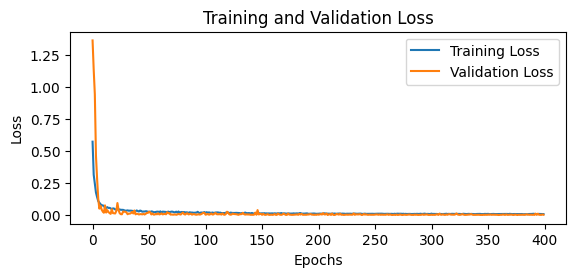

In [26]:
# Plotting the training and validation loss
plt.plot(weight_model_history.history['loss'], label='Training Loss')
plt.plot(weight_model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplots_adjust(top=0.4, bottom=0.0)

plt.show()

In [27]:
print(f"Linear Regression model loss is : {linear_history.history['loss'][-1]}\nMLP model loss is: {mlp_history.history['loss'][-1]}\nMLP model with updated weights loss is : {weight_model_history.history['loss'][-1]}")

Linear Regression model loss is : 0.17875751852989197
MLP model loss is: 0.010297269560396671
MLP model with updated weights loss is : 0.009860338643193245


## Modeling with CNN

In [33]:
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(260, 1)),
    MaxPooling1D(2),

    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),

    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),

    Flatten(),

    Dense(64, activation='relu'),

    Dense(1)
])

cnn_model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae', 'mse'])

cnn_model.summary()

# Train the model
cnn_model_history = cnn_model.fit(X_train_preprocessed, y_train,
                    validation_data=(X_valid_preprocessed, y_valid),
                    epochs=400,
                    batch_size=32,
                    verbose=2)

# Evaluate the model on the validation set
cnn_model_evalutaion_result = cnn_model.evaluate(X_valid_preprocessed, y_valid, verbose=0)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 258, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 129, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 127, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 63, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 61, 128)           24704     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 30, 128)          

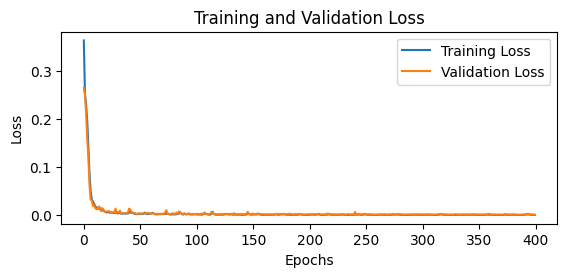

In [36]:
# Plotting the training and validation loss
plt.plot(cnn_model_history.history['loss'], label='Training Loss')
plt.plot(cnn_model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplots_adjust(top=0.4, bottom=0.0)

plt.show()

In [37]:
print(f"Linear Regression model loss is : {linear_history.history['loss'][-1]}\nMLP model loss is: {mlp_history.history['loss'][-1]}\nMLP model with updated weights loss is : {weight_model_history.history['loss'][-1]}\nCNN model loss is: {cnn_model_history.history['loss'][-1]}")

Linear Regression model loss is : 0.17875751852989197
MLP model loss is: 0.010297269560396671
MLP model with updated weights loss is : 0.009860338643193245
CNN model loss is: 0.0002573301026131958


In [40]:
print(f"Linear Regression model loss is : {linear_history.history['val_loss'][-1]}\nMLP model loss is: {mlp_history.history['val_loss'][-1]}\nMLP model with updated weights loss is : {weight_model_history.history['val_loss'][-1]}\nCNN model loss is: {cnn_model_history.history['val_loss'][-1]}")


Linear Regression model loss is : 0.2566473186016083
MLP model loss is: 0.0273283701390028
MLP model with updated weights loss is : 0.004908374510705471
CNN model loss is: 0.0007745694019831717
